## Posterization

In [53]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage import color
from sklearn.neighbors import NearestCentroid # Using NearestCentroid for efficient mapping
import os # Import os for file existence check

def posterize_with_palette(image, palette_rgb):
    """
    Posterizes an image using a given color palette.

    Args:
        image (PIL.Image.Image): The input image (preferably in RGB mode).
        palette_rgb (list): A list of RGB color tuples (0-255) representing the palette.

    Returns:
        PIL.Image.Image: The posterized image in RGB mode, or None if an error occurs.
    """
    if not palette_rgb:
        print("Error: Provided palette is empty.")
        return None

    try:
        # Ensure image is in RGB mode
        img_rgb = image.convert('RGB')
        img_array = np.array(img_rgb)
        original_dimensions = img_array.shape[:2] # (height, width)

        # Convert original image pixels to CIELAB
        pixels_lab_original = color.rgb2lab(img_array / 255.0).reshape(-1, 3)

        # Convert the palette colors to CIELAB
        palette_lab = color.rgb2lab(np.array(palette_rgb) / 255.0)

        # Use NearestCentroid to find the closest palette color in CIELAB for each pixel
        # We fit NearestCentroid with the palette colors as features and their indices as labels
        clf = NearestCentroid()
        clf.fit(palette_lab, np.arange(len(palette_lab)))

        # Predict the index of the closest palette color for each original pixel
        closest_palette_indices = clf.predict(pixels_lab_original)

        # Create the posterized image array
        posterized_img_array = np.zeros_like(img_array)
        pixel_index = 0
        for i in range(original_dimensions[0]): # Height
            for j in range(original_dimensions[1]): # Width
                palette_index = closest_palette_indices[pixel_index]
                posterized_img_array[i, j, :] = palette_rgb[palette_index]
                pixel_index += 1

        # Convert the NumPy array back to a Pillow Image
        posterized_img = Image.fromarray(posterized_img_array, 'RGB')

        return posterized_img

    except Exception as e:
        print(f"An error occurred during posterization: {e}")
        return None

## Octree, Median Cut and MaxCoverage

In [61]:
from PIL import Image

import os

import matplotlib.pyplot as plt

import numpy as np


def quantize_image(image_path, num_colors, method):

    """

    Quantizes an image using a specified method to a specified number of colors.


    Args:

        image_path (str): The path to the input image file.

        num_colors (int): The desired number of colors in the quantized image (max 256).

        method: The quantization method to use (e.g., Image.Quantize.FASTOCTREE).


    Returns:

        PIL.Image.Image: The quantized image in 'P' mode (paletted), or None if an error occurs.

    """

    if not 2 <= num_colors <= 256:

        print("Error: Number of colors must be between 2 and 256 for paletted images.")

        return None


    if not os.path.exists(image_path):

        print(f"Error: Image file not found at {image_path}")

        return None


    try:

        # Open the image

        img = Image.open(image_path)


        # Ensure the image is in a suitable mode (e.g., RGB) before quantizing

        # Convert to RGB if not already to handle potential alpha channels etc.

        if img.mode != 'RGB':

            print(f"  Converting image from {img.mode} to RGB...")

            #img = img.convert('RGB')

            img = Image.open(image_path)

            arr = np.array(img)

            alpha_mask = arr[..., 3] > 0

            img = arr[alpha_mask, :3]

            img = Image.fromarray(img, 'RGBA')

           


        # Perform color quantization with the specified method

        print(f"  Quantizing image to {num_colors} colors using {method.name}...")

        quantized_img = img.quantize(colors=num_colors, method=method)

        print("  Quantization complete.")


        return quantized_img


    except Exception as e:

        print(f"  An error occurred during quantization with {method.name}: {e}")

        return None


def display_palette(quantized_image, num_colors, method_name):

    """Displays the color palette of a quantized image."""

    if quantized_image is None:

        return


    try:

        palette = quantized_image.getpalette()

        colors_rgb = []

        for i in range(num_colors):

             r = palette[i * 3]

             g = palette[i * 3 + 1]

             b = palette[i * 3 + 2]

             colors_rgb.append((r, g, b))


        colors_normalized = np.array(colors_rgb) / 255.0


        fig, ax = plt.subplots(1, 1, figsize=(num_colors * 0.5, 2))

        ax.imshow([colors_normalized], aspect='auto')

        ax.set_xticks([])

        ax.set_yticks([])

        ax.set_title(f'Palette for {method_name} ({len(colors_rgb)} colors)')

        plt.show()

    except Exception as e:

        print(f"Error displaying palette for {method_name}: {e}") 

Original Image:


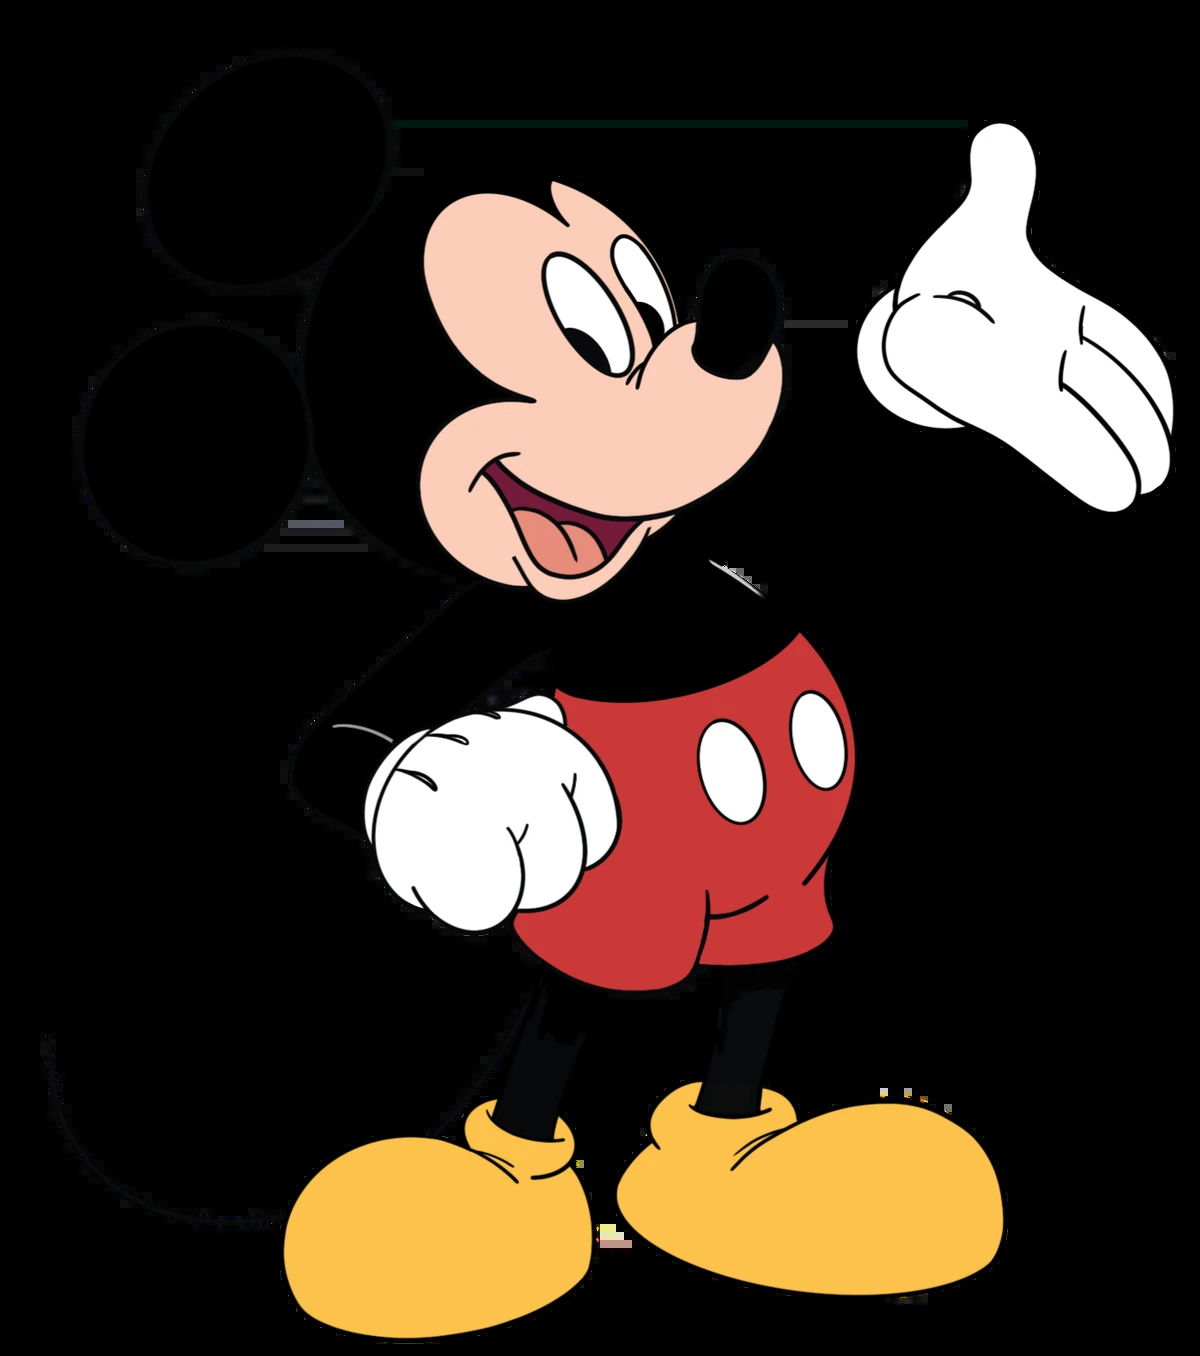


--- Results for Median Cut ---
  Converting image from RGBA to RGB...
  An error occurred during quantization with MEDIANCUT: buffer is not large enough
  Quantization failed for Median Cut.

--- Results for Maximum Coverage ---
  Converting image from RGBA to RGB...
  An error occurred during quantization with MAXCOVERAGE: buffer is not large enough
  Quantization failed for Maximum Coverage.

--- Results for Fast Octree ---
  Converting image from RGBA to RGB...
  An error occurred during quantization with FASTOCTREE: buffer is not large enough
  Quantization failed for Fast Octree.

--- Comparison Complete ---


In [62]:
# --- User Input ---

input_image_path = "mickey.png" # <--- Change this to your image file path

desired_colors = 6 # <--- Change this to the desired number of colors (2-256)

# ------------------


# Define the quantization methods to iterate through

quantization_methods = {

    "Median Cut": Image.Quantize.MEDIANCUT,

    "Maximum Coverage": Image.Quantize.MAXCOVERAGE,

    "Fast Octree": Image.Quantize.FASTOCTREE

}


# Check if the input image file exists

if not os.path.exists(input_image_path):

    print(f"Error: Input image file not found at {input_image_path}")

else:

    # Open and display the original image first

    print("Original Image:")

    original_img = Image.open(input_image_path).convert('RGB') # Ensure original is in RGB

    display(original_img)


    # Iterate through each quantization method

    for method_name, method_value in quantization_methods.items():

        print(f"\n--- Results for {method_name} ---")


        # Quantize the image using the current method (creates a paletted image)

        quantized_image = quantize_image(input_image_path, desired_colors, method_value)


        if quantized_image:

            # Display the quantized image

            print(f"Quantized Image ({method_name}):")

            display(quantized_image)


            # *** CORRECTED PART: Extract the palette from the quantized image ***

            try:

                # Get the flat palette list (768 values)

                flat_palette = quantized_image.getpalette()


                # Convert the flat palette list to a list of RGB tuples (0-255)

                extracted_palette_rgb = []

                # The palette list has 768 entries (256 colors * 3 channels).

                # We need to extract the first `desired_colors` entries as RGB tuples.

                for i in range(desired_colors):

                    r = flat_palette[i * 3]

                    g = flat_palette[i * 3 + 1]

                    b = flat_palette[i * 3 + 2]

                    extracted_palette_rgb.append((r, g, b))


                # Display the extracted color palette visually

                display_palette(quantized_image, desired_colors, method_name) # This function still just displays


                # Now pass the correctly extracted palette to the posterize function

                print("\nPosterizing original image using the extracted palette:")

                posterized_image = posterize_with_palette(original_img, extracted_palette_rgb)

                display(posterized_image)



            except Exception as e:

                 print(f"An error occurred while processing palette or posterizing for {method_name}: {e}")


        else:

            print(f"  Quantization failed for {method_name}.")


    print("\n--- Comparison Complete ---") 

## K-means

Original Image:


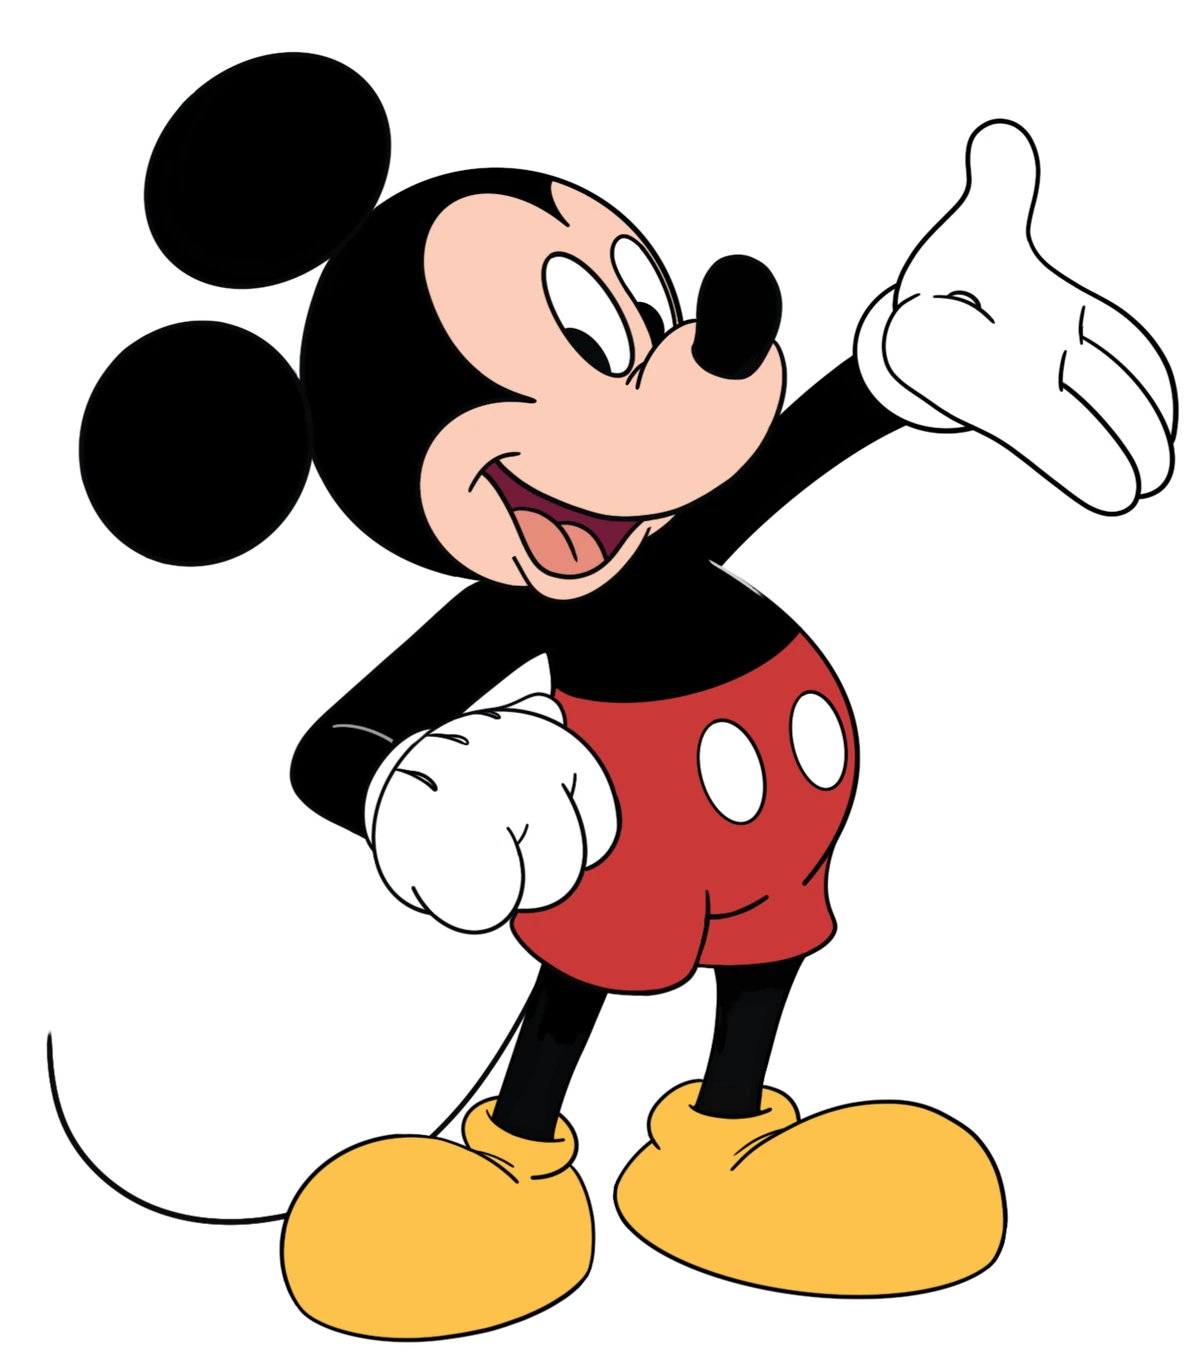

Performing K-Means clustering in CIELAB with 6 clusters...
Clustering complete.

Quantized Image (CIELAB K-Means):


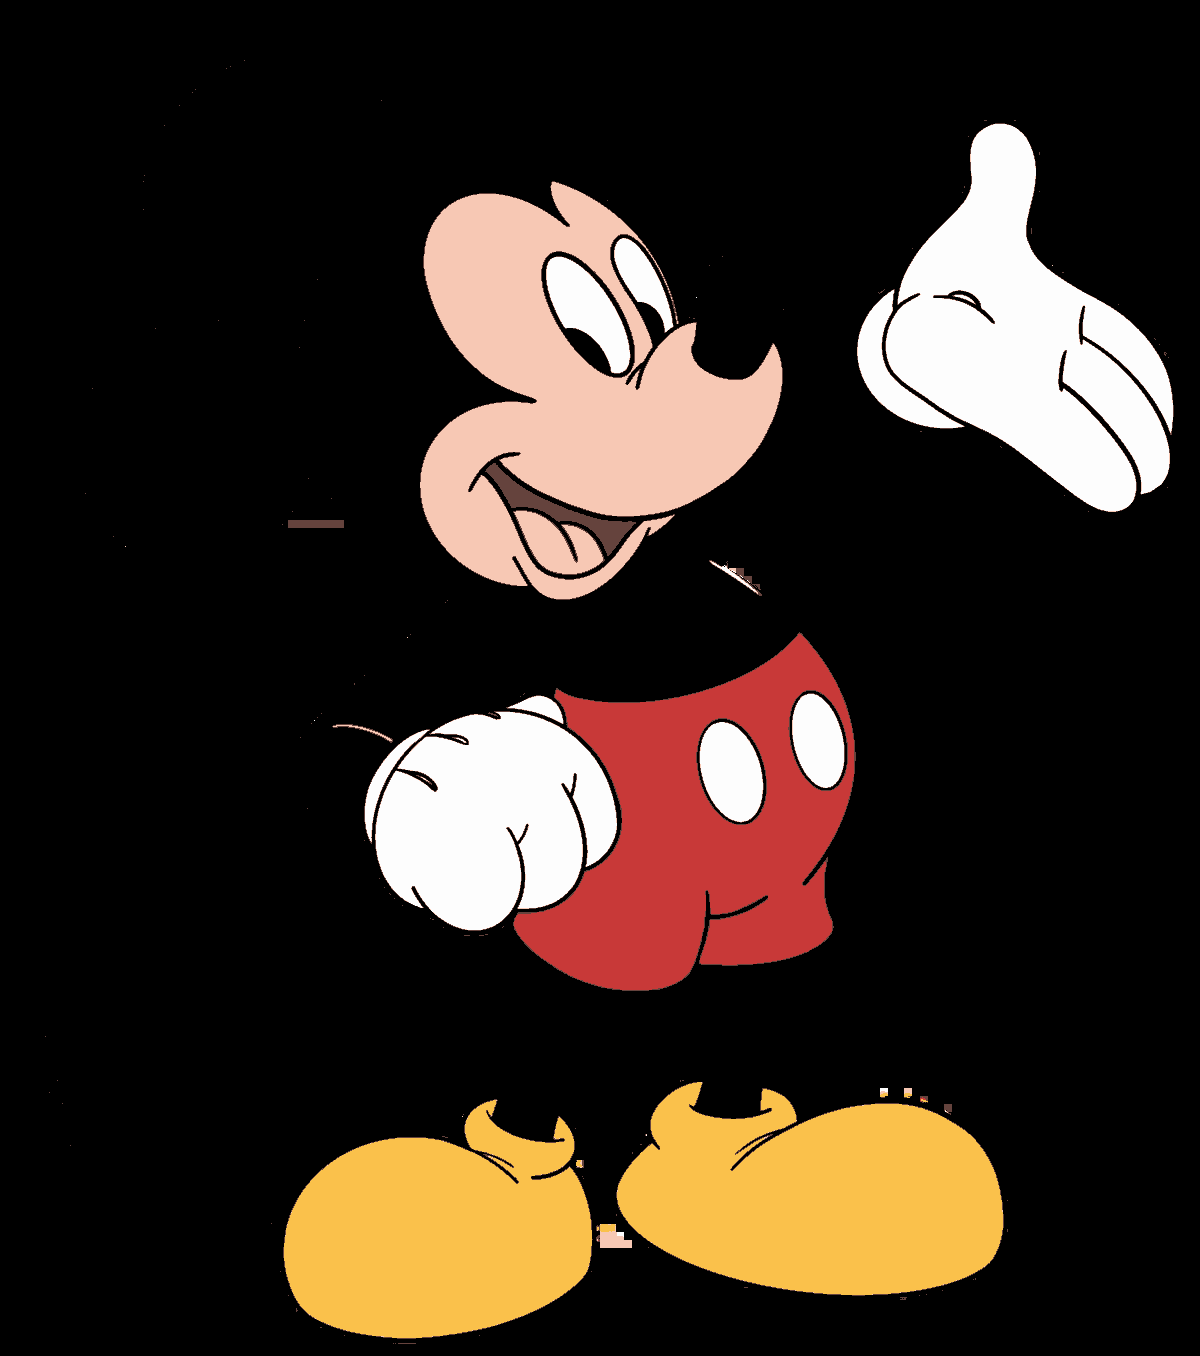

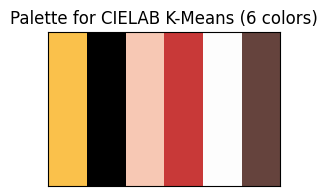


Posterizing original image using the extracted palette:


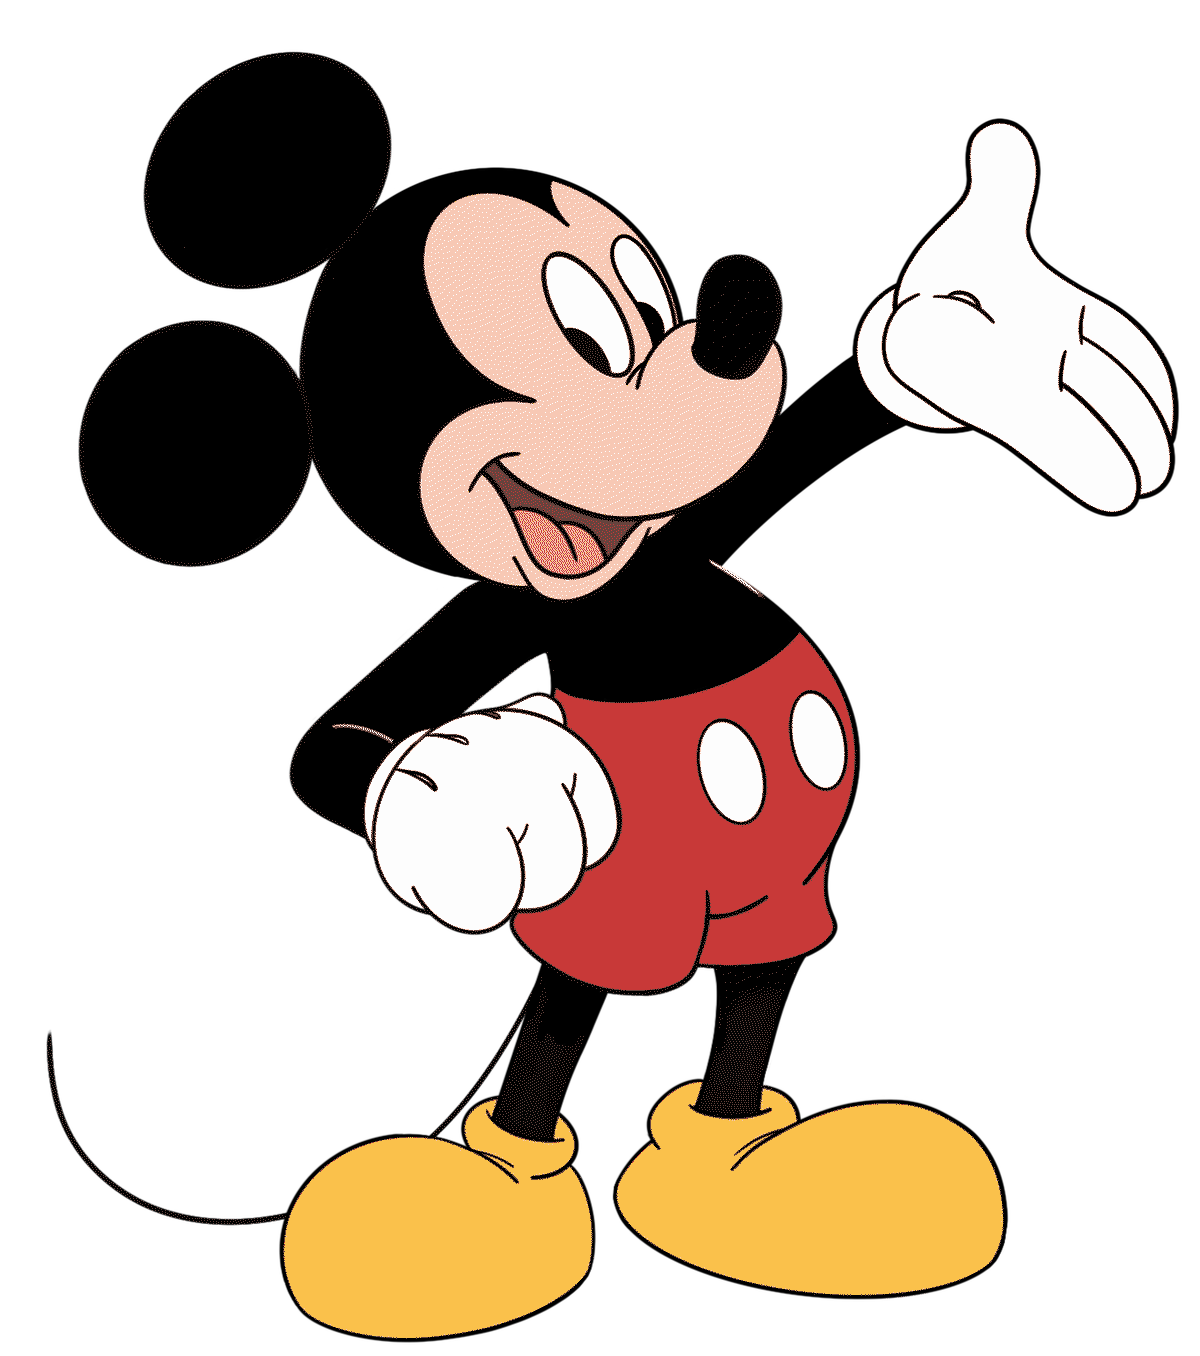

In [63]:
from skimage import color # Use skimage for color space conversion
from sklearn.cluster import KMeans # Use scikit-learn for K-Means clustering

def quantize_image_cielab(image_path, num_colors):
    """
    Quantizes an image using K-Means clustering in the CIELAB color space.

    Args:
        image_path (str): The path to the input image file.
        num_colors (int): The desired number of colors in the quantized image.

    Returns:
        tuple: A tuple containing:
            - PIL.Image.Image: The quantized image in 'RGB' mode.
            - list: The color palette as a list of RGB tuples (0-255), or None if an error occurs.
    """
    if not os.path.exists(image_path):
        print(f"Error: Image file not found at {image_path}")
        return None, None

    try:
        # Open the image and convert to RGB
        img = Image.open(image_path).convert('RGB')
        img_array = np.array(img)

        # Convert RGB to CIELAB
        # skimage expects float in range [0, 1] for RGB to Lab conversion
        img_lab = color.rgb2lab(img_array / 255.0)

        # Reshape the CIELAB image data into a list of pixels
        pixels_lab = img_lab.reshape(-1, 3)

        # Apply K-Means clustering to the CIELAB pixels
        print(f"Performing K-Means clustering in CIELAB with {num_colors} clusters...")
        kmeans = KMeans(n_clusters=num_colors, random_state=42, n_init=10) # n_init to avoid local minima
        kmeans.fit(pixels_lab)
        print("Clustering complete.")

        # Get the cluster centers (the quantized colors in CIELAB)
        new_colors_lab = kmeans.cluster_centers_

        # Convert the CIELAB cluster centers back to RGB (0-1 range)
        new_colors_rgb_normalized = color.lab2rgb(new_colors_lab)

        # Convert RGB colors back to 0-255 range for the palette
        palette_rgb = (new_colors_rgb_normalized * 255).astype(np.uint8).tolist()

        # Create the quantized image using the cluster labels
        labels = kmeans.labels_
        quantized_img_array = np.zeros_like(img_array)
        pixel_index = 0
        for i in range(img_array.shape[0]):
            for j in range(img_array.shape[1]):
                # Assign the RGB color of the cluster center to each pixel
                quantized_img_array[i, j, :] = palette_rgb[labels[pixel_index]]
                pixel_index += 1

        # Convert the quantized NumPy array back to a Pillow Image
        quantized_img = Image.fromarray(quantized_img_array, 'RGB')

        return quantized_img, palette_rgb

    except Exception as e:
        print(f"An error occurred during CIELAB quantization: {e}")
        return None, None

def display_rgb_palette(palette_rgb, method_name="CIELAB K-Means"):
    """Displays a color palette from a list of RGB tuples."""
    if palette_rgb is None:
        return

    try:
        # Convert RGB values to a format suitable for Matplotlib (0-1 range)
        colors_normalized = np.array(palette_rgb) / 255.0

        fig, ax = plt.subplots(1, 1, figsize=(len(palette_rgb) * 0.5, 2))
        ax.imshow([colors_normalized], aspect='auto')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f'Palette for {method_name} ({len(palette_rgb)} colors)')
        plt.show()
    except Exception as e:
        print(f"Error displaying palette for {method_name}: {e}")

# Check if the input image file exists
if not os.path.exists(input_image_path):
    print(f"Error: Input image file not found at {input_image_path}")
else:
    # Open and display the original image first
    print("Original Image:")
    original_img = Image.open(input_image_path)
    display(original_img)

    # Perform CIELAB quantization
    quantized_image_cielab, palette_km = quantize_image_cielab(input_image_path, desired_colors)

    if quantized_image_cielab:
        # Display the quantized image
        print("\nQuantized Image (CIELAB K-Means):")
        display(quantized_image_cielab)

        # Display the color palette
        display_rgb_palette(palette_km)


        # Now pass the correctly extracted palette to the posterize function
        print("\nPosterizing original image using the extracted palette:")
        posterized_image_km = posterize_with_palette(original_img, palette_km)
        display(posterized_image_km)

        # Optionally, save the quantized image
        #output_image_path_cielab = f"quantized_cielab_kmeans_{desired_colors}_colors.png"
        #try:
        #    quantized_image_cielab.save(output_image_path_cielab)
        #    print(f"\nQuantized image saved to {output_image_path_cielab}")
        #except Exception as e:
        #    print(f"  Error saving quantized image: {e}")
    else:
        print("\nCIELAB quantization failed.")

## Meanshift

Original size: 196×257
bandwidth_n_samples:  627
Downsampled to 49×64 (3136 pixels)
Estimating bandwidth…
 -> bandwidth = 15.153
Fitting MeanShift…
Found 7 MS clusters
Reducing palette to 8 colors…
Reconstructing full-resolution image…

Quantized Image:


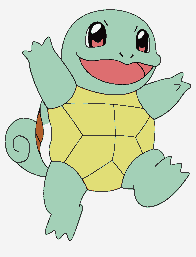


Final Reduced Palette:


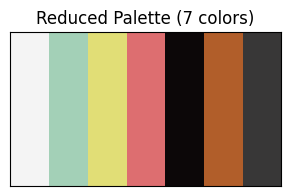


Posterizing original image using the extracted palette:


C:\Users\adamk\AppData\Roaming\Python\Python313\site-packages\sklearn\neighbors\_nearest_centroid.py:241: RuntimeWarning: invalid value encountered in divide
  np.sqrt(variance.sum(axis=0) / (n_samples - n_classes)), copy=False


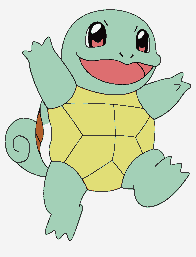

In [ ]:
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import color
from sklearn.cluster import MeanShift, KMeans, estimate_bandwidth
from sklearn.neighbors import NearestNeighbors

# Helper to display an RGB palette
def display_rgb_palette(palette_rgb, title="Color Palette"):
    if not palette_rgb:
        print("No palette to display.")
        return
    colors = np.array(palette_rgb) / 255.0
    fig, ax = plt.subplots(1, 1, figsize=(len(palette_rgb)*0.5, 2))
    ax.imshow([colors], aspect='auto')
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_title(f'{title} ({len(palette_rgb)} colors)')
    plt.show()

# Function to reduce a CIELAB palette via K‑Means
def reduce_palette_kmeans(initial_palette_lab, target_colors):
    if initial_palette_lab is None or len(initial_palette_lab) <= target_colors:
        return initial_palette_lab
    kmeans = KMeans(n_clusters=target_colors, random_state=42, n_init=10)
    kmeans.fit(initial_palette_lab)
    return kmeans.cluster_centers_

# ——————————————— User Inputs ———————————————
input_image_path        = "mickey.png"
downsample_factor       = 0.25    # fraction of original dimensions to process
bandwidth_quantile      = 0.2 # lower is more colors higher is less
bandwidth_percent_samples  = 20
desired_final_colors    = 8
# —————————————————————————————————————————————

if not os.path.exists(input_image_path):
    raise FileNotFoundError(f"'{input_image_path}' not found")

# 1) Load full‑res image
orig_img = Image.open(input_image_path).convert('RGB')
orig_w, orig_h = orig_img.size
orig_array = np.array(orig_img)
orig_lab   = color.rgb2lab(orig_array / 255.0)

print(f"Original size: {orig_w}×{orig_h}")

# 2) Downsample for bandwidth estimation & MS clustering
ds_w = max(1, int(orig_w * downsample_factor))
ds_h = max(1, int(orig_h * downsample_factor))
ds_img = orig_img.resize((ds_w, ds_h), resample=Image.LANCZOS)
ds_array = np.array(ds_img)
ds_lab   = color.rgb2lab(ds_array / 255.0)
pixels_ds = ds_lab.reshape(-1, 3)

bandwidth_n_samples = int(ds_w * ds_h * (bandwidth_percent_samples/100))
print("bandwidth_n_samples: ", bandwidth_n_samples);
print(f"Downsampled to {ds_w}×{ds_h} ({pixels_ds.shape[0]} pixels)")

# 3) Estimate bandwidth on a (random) subset
print("Estimating bandwidth…")
bw = estimate_bandwidth(
    pixels_ds, quantile=bandwidth_quantile,
    n_samples=bandwidth_n_samples, random_state=42)
print(f" -> bandwidth = {bw:.3f}")

# 4) Fit MeanShift on downsampled pixels
print("Fitting MeanShift…")
ms = MeanShift(bandwidth=bw, cluster_all=False, n_jobs=-1)
ms.fit(pixels_ds)
initial_palette_lab = ms.cluster_centers_
print(f"Found {len(initial_palette_lab)} MS clusters")

# 5) Reduce palette via K‑Means
print(f"Reducing palette to {desired_final_colors} colors…")
reduced_palette_lab = reduce_palette_kmeans(initial_palette_lab, desired_final_colors)

# Convert reduced CIELAB → RGB
# skimage.color.lab2rgb expects shape (...,3)
lab_for_conv = reduced_palette_lab.reshape(1, -1, 3)
reduced_palette_rgb = (
    color.lab2rgb(lab_for_conv)[0] * 255
).astype(np.uint8).tolist()

# 6) Reconstruct full‑res image by nearest‑neighbor lookup
print("Reconstructing full-resolution image…")
pixels_orig = orig_lab.reshape(-1, 3)

nn = NearestNeighbors(n_neighbors=1).fit(reduced_palette_lab)
_, idx = nn.kneighbors(pixels_orig)

quant_array = np.array(reduced_palette_rgb, dtype=np.uint8)[idx.flatten()]
quant_array = quant_array.reshape(orig_h, orig_w, 3)

quant_img = Image.fromarray(quant_array, 'RGB')

# 7) Display results
print("\nQuantized Image:")
display(quant_img)

print("\nFinal Reduced Palette:")
display_rgb_palette(reduced_palette_rgb, title="Reduced Palette")

# Now pass the correctly extracted palette to the posterize function
print("\nPosterizing original image using the extracted palette:")
posterized_image_ms = posterize_with_palette(original_img, reduced_palette_rgb)
display(posterized_image_ms)


## Median Filtering

In [9]:
from PIL import Image, ImageFilter
from sklearn.neighbors import NearestCentroid

def apply_median_filter_and_remap(image, size, original_palette_rgb):
    """
    Applies a median filter to an image and then remaps colors to the original palette.
    Prints the number of unique colors before and after the process.

    Args:
        image (PIL.Image.Image): The input image (preferably in RGB mode, expected to have limited colors).
        size (int): The size of the median filter kernel (e.g., 3 for 3x3).
        original_palette_rgb (list): The list of RGB color tuples (0-255) from the original limited palette.

    Returns:
        PIL.Image.Image: The median-filtered and remapped image in RGB mode, or None if an error occurs.
    """
    if not original_palette_rgb:
        print("Error: Original palette is empty.")
        return None

    try:
        # Ensure image is in RGB mode and convert to numpy array
        img_rgb = image.convert('RGB')
        img_array = np.array(img_rgb)

        # --- Count unique colors BEFORE filtering ---
        unique_colors_before = len(set(tuple(p) for row in img_array for p in row))
        print(f"Unique colors BEFORE median filtering and remapping: {unique_colors_before}")
        # ------------------------------------------

        # --- Apply the median filter ---
        print(f"Applying median filter with size {size}...")
        filtered_image = img_rgb.filter(ImageFilter.MedianFilter(size=size))
        filtered_img_array = np.array(filtered_image)
        print("Median filtering complete.")
        # -------------------------------

        # --- Remap colors to the original palette ---
        print("Remapping colors to the original palette...")

        # Convert filtered image pixels to CIELAB
        filtered_pixels_lab = color.rgb2lab(filtered_img_array / 255.0).reshape(-1, 3)

        # Convert the original palette colors to CIELAB
        original_palette_lab = color.rgb2lab(np.array(original_palette_rgb) / 255.0)

        # Use NearestCentroid to find the closest palette color in CIELAB for each filtered pixel
        clf = NearestCentroid()
        clf.fit(original_palette_lab, np.arange(len(original_palette_lab)))

        # Predict the index of the closest palette color for each filtered pixel
        closest_palette_indices = clf.predict(filtered_pixels_lab)

        # Create the remapped image array
        remapped_img_array = np.zeros_like(img_array)
        original_dimensions = img_array.shape[:2] # (height, width)
        pixel_index = 0
        for i in range(original_dimensions[0]): # Height
            for j in range(original_dimensions[1]): # Width
                palette_index = closest_palette_indices[pixel_index]
                remapped_img_array[i, j, :] = original_palette_rgb[palette_index]
                pixel_index += 1
        print("Color remapping complete.")
        # -------------------------------------------

        # --- Count unique colors AFTER remapping ---
        unique_colors_after = len(set(tuple(p) for row in remapped_img_array for p in row))
        print(f"Unique colors AFTER median filtering and remapping: {unique_colors_after}")
        # -----------------------------------------


        # Convert the remapped NumPy array back to a Pillow Image
        remapped_image = Image.fromarray(remapped_img_array, 'RGB')

        return remapped_image

    except Exception as e:
        print(f"An error occurred during median filtering and remapping: {e}")
        return None

Unique colors BEFORE median filtering and remapping: 8
Applying median filter with size 1...
Median filtering complete.
Remapping colors to the original palette...
Color remapping complete.
Unique colors AFTER median filtering and remapping: 8
Median filtering complete.

Original Posterized Image:


C:\Users\adamk\AppData\Roaming\Python\Python313\site-packages\sklearn\neighbors\_nearest_centroid.py:241: RuntimeWarning: invalid value encountered in divide
  np.sqrt(variance.sum(axis=0) / (n_samples - n_classes)), copy=False


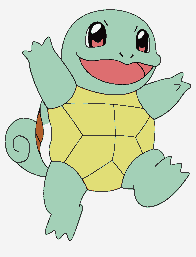


Median Filtered Image (size=1):


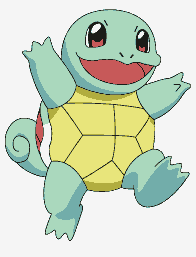

In [12]:
# --- User Input ---
median_filter_size = 1 # <--- Adjust the size of the median filter kernel (e.g., 3, 5)
# ------------------


# Apply the median filter
median_filtered_image = apply_median_filter_and_remap(posterized_image_km, median_filter_size, palette_km)

if median_filtered_image:
    print("Median filtering complete.")
    print("\nOriginal Posterized Image:")
    display(posterized_image_ms)

    print(f"\nMedian Filtered Image (size={median_filter_size}):")
    display(median_filtered_image)

        

## Minority Pixel Removal and Area Thresholding

In [13]:
from skimage.measure import label, regionprops # Import label and regionprops
from collections import Counter # To count neighboring colors
import numpy as np # Import numpy
from PIL import Image # Import Pillow Image

def remove_minority_pixels(image, area_threshold):
    """
    Removes connected components of pixels with an area below a threshold,
    replacing them with the color of the largest neighboring component.
    This version refines neighbor counting and explicitly handles border pixels
    by checking neighbor bounds.

    Args:
        image (PIL.Image.Image): The input image (preferably in RGB mode),
                                 expected to have a limited number of colors (e.g., after posterization).
        area_threshold (int): The minimum area (number of pixels) for a color region to be kept.

    Returns:
        PIL.Image.Image: The image with minority pixels removed, or None if an error occurs.
    """
    try:
        # Ensure image is in RGB mode and convert to numpy array
        img_rgb = image.convert('RGB')
        img_array = np.array(img_rgb)
        img_height, img_width = img_array.shape[:2]

        # Get unique colors and create a mapping from RGB tuple to integer ID
        # This is necessary because skimage.measure.label works on integer arrays
        unique_colors_rgb = list(set(tuple(p) for row in img_array for p in row))
        print(f"Unique colors found: {len(unique_colors_rgb)}")
        rgb_to_id = {color: i + 1 for i, color in enumerate(unique_colors_rgb)} # Use 1-based indexing for labels
        id_to_rgb = {i + 1: color for i, color in enumerate(unique_colors_rgb)}

        # Create an integer-labeled image based on color IDs
        labeled_img_id = np.zeros((img_height, img_width), dtype=int)
        for i in range(img_height):
            for j in range(img_width):
                labeled_img_id[i, j] = rgb_to_id[tuple(img_array[i, j])]

        # Perform connected component labeling
        # connectivity=2 considers diagonal neighbors as connected
        # background=0 means pixels with value 0 are not labeled
        # We used 1-based indexing for our color IDs, so 0 is a safe background
        label_image = label(labeled_img_id, connectivity=2, background=0)
        regions = regionprops(label_image)

        # Create a copy of the image array to modify
        cleaned_img_array = np.copy(img_array)

        # Identify and process small components
        print(f"Processing regions with area less than threshold ({area_threshold})...")
        for region in regions:
            if region.area < area_threshold:
                # This region is smaller than the threshold, remove it
                # Find neighboring pixels and their labels/colors
                neighbor_label_counts = Counter()
                # Iterate through pixels in the small region and check their neighbors
                for r, c in region.coords:
                    for dr in [-1, 0, 1]:
                        for dc in [-1, 0, 1]:
                            if dr == 0 and dc == 0:
                                continue # Skip the pixel itself
                            nr, nc = r + dr, c + dc
                            # Check if neighbor is within image bounds. This correctly handles border pixels.
                            if 0 <= nr < img_height and 0 <= nc < img_width:
                                neighbor_label = label_image[nr, nc]
                                # Only consider neighbors that are NOT part of the current small region
                                if neighbor_label != region.label:
                                    neighbor_label_counts[neighbor_label] += 1 # Count occurrences of neighbor labels

                # Find the most frequent neighboring label that corresponds to a LARGE component
                most_frequent_large_neighbor_label = None
                if neighbor_label_counts:
                    for neighbor_label, count in neighbor_label_counts.most_common():
                        # Find the region properties for this neighbor label
                        neighbor_region = None
                        # region.label is 1-based, so we need to find the corresponding region in the list
                        for reg in regions:
                            if reg.label == neighbor_label:
                                neighbor_region = reg
                                break # Found the neighbor region properties

                        # Check if the neighbor region is large enough
                        if neighbor_region and neighbor_region.area >= area_threshold:
                            most_frequent_large_neighbor_label = neighbor_label
                            break # Found the dominant large neighbor

                # If a dominant large neighbor is found, fill the small region with its color
                if most_frequent_large_neighbor_label is not None:
                    # Get the color of the dominant large neighbor region
                    # We can get the color from any pixel within that neighbor region
                    # For simplicity, let's find its first pixel and get its color from the original array
                    # Note: region.label is 1-based, list index is 0-based.
                    # We need to find the region object with the matching label.
                    fill_color_rgb = None
                    for reg in regions:
                        if reg.label == most_frequent_large_neighbor_label:
                            # Get the color from the first coordinate of the neighbor region
                            if reg.coords.size > 0:
                                r_fill, c_fill = reg.coords[0]
                                fill_color_id = labeled_img_id[r_fill, c_fill]
                                fill_color_rgb = id_to_rgb[fill_color_id]
                            break # Found the neighbor region

                    if fill_color_rgb is not None:
                        # Fill the small region with the fill color
                        for r, c in region.coords:
                            cleaned_img_array[r, c, :] = fill_color_rgb
                # else:
                    # If no large neighbor is found (e.g., small region at the border surrounded by
                    # other small regions or the image edge), it remains with its original color.
                    # This is the intended behavior based on the logic to fill only if a large neighbor exists.


        print("Minority pixel removal complete.")
        # Convert the cleaned NumPy array back to a Pillow Image
        cleaned_img = Image.fromarray(cleaned_img_array, 'RGB')

        return cleaned_img

    except Exception as e:
        print(f"An error occurred during minority pixel removal: {e}")
        return None


Removing minority pixels with area less than 1...
Unique colors found: 8
Processing regions with area less than threshold (1)...
Minority pixel removal complete.
Minority pixel removal complete.

Original Image (before removal):


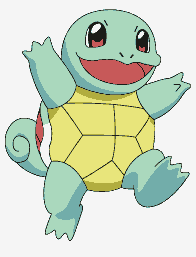


Image after removing regions < 1 pixels:


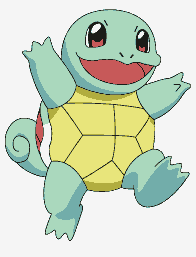

In [15]:
# --- User Input ---
area_threshold = 1 # <--- Set the minimum area for a region to be kept. Adjust this value.
# ------------------

image_to_clean = median_filtered_image


if image_to_clean is not None:
    print(f"\nRemoving minority pixels with area less than {area_threshold}...")
    cleaned_image = remove_minority_pixels(image_to_clean, area_threshold)

    if cleaned_image:
        print("Minority pixel removal complete.")
        print("\nOriginal Image (before removal):")
        display(image_to_clean)

        print(f"\nImage after removing regions < {area_threshold} pixels:")
        display(cleaned_image)

        # Optionally, save the cleaned image
        # output_image_path_cleaned = f"image_cleaned_threshold_{area_threshold}.png"
        # try:
        #     cleaned_image.save(output_image_path_cleaned)
        #     print(f"\nCleaned image saved to {output_image_path_cleaned}")
        # except Exception as e:
        #     print(f"  Error saving cleaned image: {e}")
    else:
        print("\nMinority pixel removal failed.")
else:
    print("No suitable image found to apply minority pixel removal. Please run previous cells.")